In [1]:
# pip install pyspark

In [1]:
# seetup java
import os
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-18.0.2.1"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]

In [2]:
# create session 

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("E-commerce User Behavior Analysis").config("spark.local.dir", "D:\\IUGAZA\\Big Data\\project\\spark-temp").config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").config("spark.executor.cores", "4").config("spark.driver.maxResultSize", "4g").getOrCreate()



In [3]:
print("Driver Memory:", spark.sparkContext.getConf().get("spark.driver.memory"))
print("Executor Cores:", spark.sparkContext.defaultParallelism)


Driver Memory: 8g
Executor Cores: 12


In [4]:
from pyspark.sql.types import StructType, StructField, LongType, StringType

schema = StructType([
    StructField("user_id",     LongType(),  True),
    StructField("item_id",     LongType(),  True),
    StructField("category_id", LongType(),  True),
    StructField("behavior_type", StringType(), True),  # 'pv','cart','fav','buy'
    StructField("timestamp",   LongType(),  True)      # Unix seconds
])

df_ori = spark.read.csv("D:\\IUGAZA\\Big Data\\project\\UserBehavior.csv", schema=schema)

In [5]:
df_ori.printSchema()


root
 |-- user_id: long (nullable = true)
 |-- item_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- timestamp: long (nullable = true)



In [6]:
df_ori.show(5, truncate=False)

+-------+-------+-----------+-------------+----------+
|user_id|item_id|category_id|behavior_type|timestamp |
+-------+-------+-----------+-------------+----------+
|1      |2268318|2520377    |pv           |1511544070|
|1      |2333346|2520771    |pv           |1511561733|
|1      |2576651|149192     |pv           |1511572885|
|1      |3830808|4181361    |pv           |1511593493|
|1      |4365585|2520377    |pv           |1511596146|
+-------+-------+-----------+-------------+----------+
only showing top 5 rows


In [7]:
# Print one line of each type of Behavior
from pyspark.sql.functions import when, col

pageview1 = df_ori.filter(col("behavior_type") == "pv").limit(1)
buy1       = df_ori.filter(col("behavior_type") == "buy").limit(1)
addtocart1 = df_ori.filter(col("behavior_type") == "cart").limit(1)
favorite1  = df_ori.filter(col("behavior_type") == "fav").limit(1)


In [8]:

sample_df1 = pageview1.union(buy1).union(addtocart1).union(favorite1)

sample_df1.show(truncate=False)

+-------+-------+-----------+-------------+----------+
|user_id|item_id|category_id|behavior_type|timestamp |
+-------+-------+-----------+-------------+----------+
|1      |2268318|2520377    |pv           |1511544070|
|100    |1603476|2951233    |buy          |1511579908|
|1000   |5120034|1051370    |cart         |1511542034|
|100    |3763048|3425094    |fav          |1511551860|
+-------+-------+-----------+-------------+----------+



In [9]:
df_count=df_ori.count()

In [10]:
print("Number of records:", df_count)

Number of records: 100150807


In [11]:
df_ori.isEmpty()

False

In [12]:
from pyspark.sql.functions import col, sum as spark_sum

df_ori.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df_ori.columns]).show()


+-------+-------+-----------+-------------+---------+
|user_id|item_id|category_id|behavior_type|timestamp|
+-------+-------+-----------+-------------+---------+
|      0|      0|          0|            0|        0|
+-------+-------+-----------+-------------+---------+



In [13]:
df_duplicates_count=df_ori.dropDuplicates().count()

In [14]:
# Number of duplicate records
duplicate_count = df_count - df_duplicates_count
print("Number of duplicate records:", duplicate_count)


Number of duplicate records: 49


In [15]:
# Filter and drop duplicate records
from pyspark.sql.functions import col

allowed = ["pv","cart","fav","buy"]
df_filtered = (df_ori
      .filter(col("behavior_type").isin(allowed))
      .dropDuplicates(["user_id","item_id","category_id","behavior_type","timestamp"])
     )



In [16]:
df_filtered_count=df_filtered.count()
print("Events after basic cleaning:",df_filtered_count)


Events after basic cleaning: 100150758


In [17]:
c=df_count-df_filtered_count
print("Number of droped records:", duplicate_count)


Number of droped records: 49


In [18]:
# Converting the timestamp and adding time columns
from pyspark.sql.functions import from_unixtime, to_timestamp, to_date, hour, dayofweek

df_clean = (df_filtered
      .withColumn("event_time", to_timestamp(from_unixtime(col("timestamp"))))
      .withColumn("event_date", to_date(col("event_time")))
      .withColumn("event_hour", hour(col("event_time")))
      .withColumn("event_dow",  dayofweek(col("event_time")))
     )

In [19]:
df_clean.show(5, truncate=False)

+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+
|user_id|item_id|category_id|behavior_type|timestamp |event_time         |event_date|event_hour|event_dow|
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+
|1      |4615417|4145813    |pv           |1511870864|2017-11-28 14:07:44|2017-11-28|14        |3        |
|1      |4666650|4756105    |pv           |1512084223|2017-12-01 01:23:43|2017-12-01|1         |6        |
|100    |4840649|1029459    |pv           |1511868574|2017-11-28 13:29:34|2017-11-28|13        |3        |
|100    |2772937|3114694    |pv           |1512192261|2017-12-02 07:24:21|2017-12-02|7         |7        |
|1000040|4966998|4145813    |pv           |1511612583|2017-11-25 14:23:03|2017-11-25|14        |7        |
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+
only showing top 5 rows


In [20]:
from pyspark.sql.functions import when, col

behavior_mapping = {
    'pv': 'PageView',
    'buy': 'Buy',
    'cart': 'AddToCart',
    'fav': 'Favorite'
}

df_clean = df_clean.withColumn(
    "behavior_type",
    when(col("behavior_type") == "pv", "PageView")
    .when(col("behavior_type") == "buy", "Buy")
    .when(col("behavior_type") == "cart", "AddToCart")
    .when(col("behavior_type") == "fav", "Favorite")
    .otherwise(col("behavior_type"))
)


In [21]:
# Print one line of each type of Behavior
pageview = df_clean.filter(col("behavior_type") == "PageView").limit(1)
buy       = df_clean.filter(col("behavior_type") == "Buy").limit(1)
addtocart = df_clean.filter(col("behavior_type") == "AddToCart").limit(1)
favorite  = df_clean.filter(col("behavior_type") == "Favorite").limit(1)

sample_df = pageview.union(buy).union(addtocart).union(favorite)

sample_df.show(truncate=False)


+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+
|user_id|item_id|category_id|behavior_type|timestamp |event_time         |event_date|event_hour|event_dow|
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+
|1      |4615417|4145813    |PageView     |1511870864|2017-11-28 14:07:44|2017-11-28|14        |3        |
|1000565|1164939|4763051    |Buy          |1511794748|2017-11-27 16:59:08|2017-11-27|16        |2        |
|1000059|3367814|982926     |AddToCart    |1512123747|2017-12-01 12:22:27|2017-12-01|12        |6        |
|1000159|1474251|1349561    |Favorite     |1511675317|2017-11-26 07:48:37|2017-11-26|7         |1        |
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+



In [22]:
from pyspark.sql.functions import col

top5_categories = (
    df_clean.groupBy("Category_ID")
    .count()
    .orderBy(col("count").desc())
    .limit(5)
)

top5_categories.show()


+-----------+-------+
|Category_ID|  count|
+-----------+-------+
|    4756105|4862531|
|    4145813|3468980|
|    2355072|3374936|
|    3607361|3170710|
|     982926|3067877|
+-----------+-------+



In [23]:
from pyspark.sql.functions import col, to_date, count

# Filtering the buying behavior only
buy_df = df_clean.filter(col("behavior_type") == "Buy")

# Extracting the date from the Datetime column
buy_df = buy_df.withColumn("event_date", to_date(col("event_time")))

# Counting the number of purchases for each day
buy_count = (
    buy_df.groupBy("event_date")
    .agg(count("*").alias("count"))
    .orderBy("event_date")
)

buy_count.show()


+----------+------+
|event_date| count|
+----------+------+
|2017-11-24| 11139|
|2017-11-25|201592|
|2017-11-26|212698|
|2017-11-27|219249|
|2017-11-28|211916|
|2017-11-29|223094|
|2017-11-30|222041|
|2017-12-01|212329|
|2017-12-02|259939|
|2017-12-03|241810|
+----------+------+



In [24]:
from pyspark.sql.functions import date_format, col, count, when
from pyspark.sql.window import Window

# Extract today from the week for purchase operations only
buy_day_of_week = (
    buy_df.withColumn("event_dow", date_format(col("event_time"), "EEEE"))  # Monday, Tuesday...
    .groupBy("event_dow")
    .agg(count("*").alias("count"))
)

# To maintain the order of the days, we add a sorting column (1=Monday ... 7=Sunday)
buy_day_of_week = buy_day_of_week.withColumn(
    "Day_order",
    when(col("event_dow") == "Monday", 1)
    .when(col("event_dow") == "Tuesday", 2)
    .when(col("event_dow") == "Wednesday", 3)
    .when(col("event_dow") == "Thursday", 4)
    .when(col("event_dow") == "Friday", 5)
    .when(col("event_dow") == "Saturday", 6)
    .when(col("event_dow") == "Sunday", 7)
)

# Sort by Day_order
buy_day_of_week = buy_day_of_week.orderBy("Day_order")

buy_day_of_week.show()


+---------+------+---------+
|event_dow| count|Day_order|
+---------+------+---------+
|   Monday|219249|        1|
|  Tuesday|211916|        2|
|Wednesday|223094|        3|
| Thursday|222041|        4|
|   Friday|223468|        5|
| Saturday|461531|        6|
|   Sunday|454508|        7|
+---------+------+---------+



In [25]:
# Conversion of daily purchase results
buy_count_pd = buy_count.toPandas()

# Convert purchase results by day of the week
buy_day_of_week_pd = buy_day_of_week.select("event_dow", "count").toPandas()


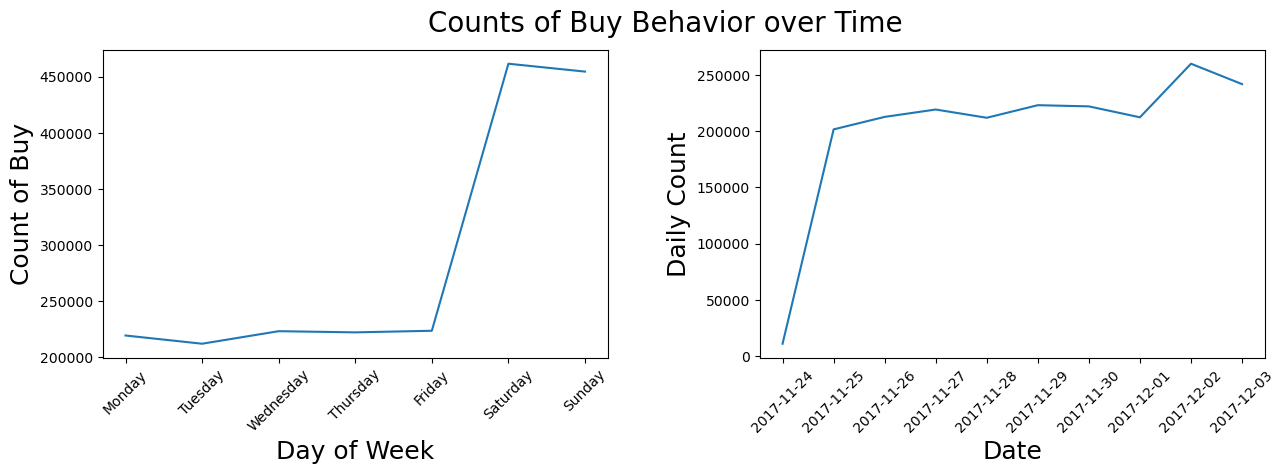

In [26]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# The plot by date
ax2.plot(buy_count_pd['event_date'], buy_count_pd['count'])
ax2.set_xlabel('Date', fontsize=18)
ax2.set_ylabel('Daily Count', fontsize=18)
ax2.tick_params(axis='x', rotation=45)

# The plot by days of the week
ax1.plot(buy_day_of_week_pd['event_dow'], buy_day_of_week_pd['count'])
ax1.set_xlabel('Day of Week', fontsize=18)
ax1.set_ylabel('Count of Buy', fontsize=18)
ax1.tick_params(axis='x', rotation=45)

f.suptitle('Counts of Buy Behavior over Time', fontsize=20)
plt.subplots_adjust(wspace=0.3)

plt.show()


In [53]:
from pyspark.sql.functions import when, col, date_format

#Extracting the day of the week (for example, Monday, Tuesday ...)
df_with_dow = df_clean.withColumn("event_dow", date_format(col("event_time"), "EEEE"))

# Add a ranking column for the days (Monday=1 ... Sunday=7)
df_with_dow = df_with_dow.withColumn(
    "Day_order",
    when(col("event_dow") == "Monday", 1)
    .when(col("event_dow") == "Tuesday", 2)
    .when(col("event_dow") == "Wednesday", 3)
    .when(col("event_dow") == "Thursday", 4)
    .when(col("event_dow") == "Friday", 5)
    .when(col("event_dow") == "Saturday", 6)
    .when(col("event_dow") == "Sunday", 7)
)

# Sort by Day_order
df_sorted = df_with_dow.orderBy("Day_order")

df_with_dow.show()


+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+---------+
|user_id|item_id|category_id|behavior_type| timestamp|         event_time|event_date|event_hour|event_dow|Day_order|
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+---------+
|      1|4615417|    4145813|     PageView|1511870864|2017-11-28 14:07:44|2017-11-28|        14|  Tuesday|        2|
|      1|4666650|    4756105|     PageView|1512084223|2017-12-01 01:23:43|2017-12-01|         1|   Friday|        5|
|    100|4840649|    1029459|     PageView|1511868574|2017-11-28 13:29:34|2017-11-28|        13|  Tuesday|        2|
|    100|2772937|    3114694|     PageView|1512192261|2017-12-02 07:24:21|2017-12-02|         7| Saturday|        6|
|1000040|4966998|    4145813|     PageView|1511612583|2017-11-25 14:23:03|2017-11-25|        14| Saturday|        6|
|1000040|4752029|     570735|     PageView|1511763248|2017-11-27

In [32]:
from pyspark.sql.functions import count

# Counting the number of behaviors per hour
hourly_behavior = (
    df_clean.groupBy("event_hour", "behavior_type")
    .agg(count("*").alias("Behavior_Count"))
)

# Converting data from Long form to Wide form (like pivot_table)
hourly_behavior_count = (
    hourly_behavior.groupBy("event_hour")
    .pivot("behavior_type")   # like columns='Behavior'
    .sum("Behavior_Count")    #like values='Behavior_Count'
    .fillna(0)                # like fill_value=0
    .orderBy("event_hour")
)

hourly_behavior_count.show(24, truncate=False)


+----------+---------+------+--------+--------+
|event_hour|AddToCart|Buy   |Favorite|PageView|
+----------+---------+------+--------+--------+
|0         |81305    |18014 |40524   |1226978 |
|1         |147046   |37679 |74666   |2229525 |
|2         |192036   |64916 |103721  |3043104 |
|3         |229890   |96134 |127976  |3729432 |
|4         |266963   |127932|147752  |4335955 |
|5         |260831   |122046|145412  |4214979 |
|6         |255811   |118591|140862  |4257322 |
|7         |279829   |123426|150844  |4655891 |
|8         |277093   |122171|148561  |4643720 |
|9         |284269   |122728|151321  |4808723 |
|10        |279035   |116444|148722  |4610033 |
|11        |255342   |101300|137631  |4205929 |
|12        |253193   |95907 |133262  |4316201 |
|13        |314774   |115032|161057  |5434301 |
|14        |393209   |133859|191406  |6590552 |
|15        |465924   |145431|219974  |7544142 |
|16        |486249   |138263|232222  |7450277 |
|17        |395920   |100070|195330  |56

In [ ]:
# How to convert a DataFrame from PySpark to Pandas
buy_count_pd = buy_count.toPandas()
buy_day_of_week_pd = buy_day_of_week.toPandas()


In [ ]:
# df_clean = df_clean.withColumn("event_dow", df_clean["event_dow"].cast(StringType()))
buy_day_of_week_pd = buy_day_of_week.toPandas()


In [48]:
df_clean.printSchema()


root
 |-- user_id: long (nullable = true)
 |-- item_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_date: date (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- event_dow: string (nullable = true)
 |-- Day_order: integer (nullable = true)



C:\Users\ITyas\AppData\Local\Temp\ipykernel_32100\1912557320.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=buy_hour_pd, x="event_hour", y="count", palette="Blues_d")
C:\Users\ITyas\AppData\Local\Temp\ipykernel_32100\1912557320.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=buy_day_of_week_pd, x="event_dow", y="count", palette="Greens_d")


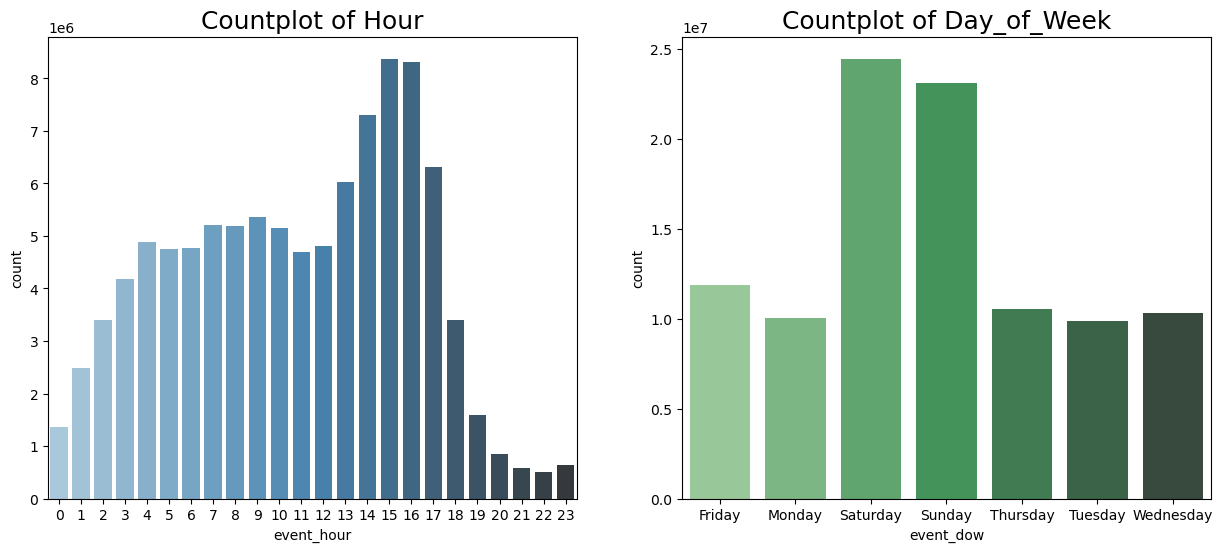

In [60]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# 1. We prepare the collection data inside Spark (small) 
# Calculating the number of events per hour

buy_hour = df_with_dow.groupBy("event_hour").count().orderBy("event_hour")

# Counting the number of events for each day of the week
buy_day_of_week = df_with_dow.groupBy("event_dow").count().orderBy("event_dow")

# 2. We convert the results to Pandas (small and easy for plotting)
buy_hour_pd = buy_hour.toPandas()
buy_day_of_week_pd = buy_day_of_week.toPandas()

# We draw using seaborn/matplotlib.
plt.figure(1, figsize=(15, 6))

# subplot 1: By the hours
plt.subplot(1, 2, 1)
sns.barplot(data=buy_hour_pd, x="event_hour", y="count", palette="Blues_d")
plt.title('Countplot of Hour', fontsize=18)

# subplot 2: On weekdays
plt.subplot(1, 2, 2)
sns.barplot(data=buy_day_of_week_pd, x="event_dow", y="count", palette="Greens_d")
plt.title('Countplot of Day_of_Week', fontsize=18)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('Countplot_of_Hour_and_Day_of_Week.png', format='png', bbox_inches='tight')
plt.show()


In [58]:
df_with_dow

DataFrame[user_id: bigint, item_id: bigint, category_id: bigint, behavior_type: string, timestamp: bigint, event_time: timestamp, event_date: date, event_hour: int, event_dow: string, Day_order: int]

In [80]:
# Time measurement with and without Spark for  Calculating the number of events per hour
import time
from pyspark.sql import SparkSession

# 1) Without Spark (baseline)

start_time = time.time()
buy_hour_with= (
    buy_hour_pd.groupby("event_hour")  
    .size()                           
    .reset_index(name="count")        
    .sort_values("event_hour")        
)
end_time = time.time()
baseline_time = end_time - start_time
print(f"Baseline runtime: {baseline_time:.4f} seconds")


# 2) With Spark

start_time = time.time()
buy_hour_spar = df_with_dow.groupBy("event_hour").count().orderBy("event_hour")
end_time = time.time()
spark_time = end_time - start_time
print(f"Spark runtime: {spark_time:.4f} seconds")

# 3) Speedup
speedup = baseline_time / spark_time if spark_time > 0 else None
print(f"Speedup: {speedup:.4f}x")


Baseline runtime: 8.1687 seconds
Spark runtime: 0.6516 seconds
Speedup: 12.5368x


In [81]:
# Time measurement with and without Spark for  Counting the number of events for each day of the week
import time
from pyspark.sql import SparkSession

# 1) Without Spark (baseline)

start_time = time.time()
buy_day_of_week_without = (
    buy_day_of_week_pd.groupby("event_dow")
    .size()
    .reset_index(name="count")
    .sort_values("event_dow")
)

end_time = time.time()
baseline_time = end_time - start_time
print(f"Baseline runtime: {baseline_time:.4f} seconds")


# 2) With Spark

start_time = time.time()
buy_day_of_week_spark = df_with_dow.groupBy("event_dow").count().orderBy("event_dow")
end_time = time.time()
spark_time = end_time - start_time
print(f"Spark runtime: {spark_time:.4f} seconds")

# 3) Speedup
speedup = baseline_time / spark_time if spark_time > 0 else None
print(f"Speedup: {speedup:.4}x")


Baseline runtime: 1.2241 seconds
Spark runtime: 0.1270 seconds
Speedup: 9.635x


In [63]:
from pyspark.sql import functions as F

result = (
    df_with_dow
    .groupBy("event_hour")
    .agg(F.count("behavior_type").alias("cnt"))
    .agg(F.sum("cnt").alias("total"))
)

result.show()


+---------+
|    total|
+---------+
|100150758|
+---------+



In [39]:
total = df_5M.count()


['event_dow', 'count', 'Day_order']


In [65]:
from pyspark.sql import functions as F

# Filter only Buy and PageView
conversion = df_with_dow.filter(df_with_dow['behavior_type'].isin(['Buy', 'PageView']))

# Count behaviors per category
conversion_counts = (
    conversion
    .groupBy('category_id', 'behavior_type')
    .agg(F.count('*').alias('count'))
    .groupBy('category_id')
    .pivot('behavior_type', ['Buy', 'PageView'])
    .sum('count')
    .fillna(0)
)

# Keep only categories where PageView >= Buy
conversion_counts = conversion_counts.filter(conversion_counts['PageView'] >= conversion_counts['Buy'])




+-----------+----+--------+--------------------+
|category_id| Buy|PageView|     Conversion_Rate|
+-----------+----+--------+--------------------+
|    1572948|1682|   15921| 0.09555189456342669|
|    2394030| 902|   20376|0.042391202180656076|
|    4578843|  40|    1569|0.024860161591050343|
|      22129|  56|   17481|0.003193248560187033|
|    2817976|  19|    1739| 0.01080773606370876|
|    2252844|   1|      19|                0.05|
|    3639576| 132|    2082| 0.05962059620596206|
|    3975787|3836|  123114|0.030216620716817643|
|    1113817| 210|    4500|0.044585987261146494|
|    2807166|  11|     433|0.024774774774774775|
|    4220062|   2|       6|                0.25|
|    3003972|   7|     978|0.007106598984771574|
|    3748100| 173|    1409| 0.10935524652338811|
|    1053937|   0|      16|                 0.0|
|    2887965| 114|    2212|0.049011177987962166|
|    2842504|   5|     646|0.007680491551459293|
|    2210217| 185|    3013| 0.05784865540963102|
|     658007|   2|  

In [66]:
from pyspark.sql import functions as F
# Add conversion rate column
conversion_counts = conversion_counts.withColumn(
    'Conversion_Rate',
    F.round(conversion_counts['Buy'] / (conversion_counts['Buy'] + conversion_counts['PageView']), 3)
)

conversion_counts.show()

+-----------+----+--------+---------------+
|category_id| Buy|PageView|Conversion_Rate|
+-----------+----+--------+---------------+
|    1572948|1682|   15921|          0.096|
|    2394030| 902|   20376|          0.042|
|    4578843|  40|    1569|          0.025|
|      22129|  56|   17481|          0.003|
|    2817976|  19|    1739|          0.011|
|    2252844|   1|      19|           0.05|
|    3639576| 132|    2082|           0.06|
|    3975787|3836|  123114|           0.03|
|    1113817| 210|    4500|          0.045|
|    2807166|  11|     433|          0.025|
|    4220062|   2|       6|           0.25|
|    3003972|   7|     978|          0.007|
|    3748100| 173|    1409|          0.109|
|    1053937|   0|      16|            0.0|
|    2887965| 114|    2212|          0.049|
|    2842504|   5|     646|          0.008|
|    2210217| 185|    3013|          0.058|
|     658007|   2|     185|          0.011|
|    1589379|  68|    2570|          0.026|
|    4737339|  52|    1978|     

In [67]:
# Top 10 categories by number of buys
conversion_10 = conversion_counts.orderBy(conversion_counts['Buy'].desc()).limit(10)
conversion_10.show()

+-----------+-----+--------+---------------+
|category_id|  Buy|PageView|Conversion_Rate|
+-----------+-----+--------+---------------+
|    1464116|34589|  684162|          0.048|
|    2735466|33730| 1116344|          0.029|
|    2885642|31844|  955203|          0.032|
|    4145813|31658| 3152237|           0.01|
|    4756105|28258| 4479754|          0.006|
|    4801426|26495| 1865520|          0.014|
|     982926|24823| 2800011|          0.009|
|    2640118|18332|  730140|          0.024|
|    4159072|18016|  188875|          0.087|
|    1320293|17137| 1794066|          0.009|
+-----------+-----+--------+---------------+



In [68]:
from pyspark.sql import functions as F

# Top categories by PageView
top10_pv_categories = (
    df_with_dow.filter(df_with_dow['behavior_type'] == 'PageView')
          .groupBy('category_id')
          .count()
          .orderBy(F.desc('count'))
)
top10_pv_categories.show()  # shows all; you can add .limit(10) if you want top 10 only




+-----------+-------+
|category_id|  count|
+-----------+-------+
|    4756105|4479754|
|    2355072|3153405|
|    4145813|3152237|
|    3607361|2977553|
|     982926|2800011|
|    2520377|2030255|
|    4801426|1865520|
|    1320293|1794066|
|    2465336|1505542|
|    3002561|1422563|
|    2735466|1116344|
|    4181361|1001627|
|     149192| 991154|
|    1080785| 960260|
|    2885642| 955203|
|    4217906| 925363|
|     154040| 906449|
|    3738615| 829421|
|    1879194| 759694|
|    2640118| 730140|
+-----------+-------+
only showing top 20 rows


In [69]:
# Top 10 categories by Buy
top10_buy_categories = (
    df_with_dow.filter(df_with_dow['behavior_type'] == 'Buy')
          .groupBy('category_id')
          .count()
          .orderBy(F.desc('count'))
          .limit(10)
)
top10_buy_categories.show()

+-----------+-----+
|category_id|count|
+-----------+-----+
|    1464116|34589|
|    2735466|33730|
|    2885642|31844|
|    4145813|31658|
|    4756105|28258|
|    4801426|26495|
|     982926|24823|
|    2640118|18332|
|    4159072|18016|
|    1320293|17137|
+-----------+-----+



In [72]:
# Top categories by PageView
from pyspark.sql import functions as F

# 1) Only "Buy" operations
buy_df = df_with_dow.filter(F.col("behavior_type") == "Buy")

# Last purchase for each user
recency = buy_df.groupBy("user_id").agg(
    F.max("event_date").alias("LastPurchaseDate")
)

# 3) Obtain the latest purchase date available in the data (latest purchase transaction)
current_date = buy_df.agg(F.max("event_date").alias("current_date")).collect()[0]["current_date"]

# 4) Recency Calculation = The difference in days between the last purchase for each user and the most recent purchase in the data.
recency = recency.withColumn(
    "Recency",
    F.datediff(F.lit(current_date), F.col("LastPurchaseDate"))
)

recency.show(5)


+-------+----------------+-------+
|user_id|LastPurchaseDate|Recency|
+-------+----------------+-------+
|1000061|      2017-12-03|      0|
|1000070|      2017-11-28|      5|
|1000313|      2017-12-02|      1|
|1001700|      2017-11-30|      3|
|1001872|      2017-11-27|      6|
+-------+----------------+-------+
only showing top 5 rows


In [73]:
from pyspark.sql import functions as F


# Count the number of purchase transactions for each User_ID
frequency = buy_df.groupBy("user_id").agg(
    F.count("behavior_type").alias("Frequency")
)

frequency.show(5)


+-------+---------+
|user_id|Frequency|
+-------+---------+
| 143889|        1|
| 237505|       10|
|1014309|        4|
| 148347|        3|
|1008961|        4|
+-------+---------+
only showing top 5 rows


In [74]:
#  join btween recency and frequency on User_ID
rfm = recency.join(frequency, on="user_id", how="inner")

# delte column LastPurshaceDate
rfm = rfm.drop("LastPurshaceDate")

rfm.show(5)


+-------+----------------+-------+---------+
|user_id|LastPurchaseDate|Recency|Frequency|
+-------+----------------+-------+---------+
|     65|      2017-12-03|      0|        2|
|     77|      2017-12-02|      1|        2|
|    113|      2017-12-02|      1|        1|
|    126|      2017-11-29|      4|        1|
|    130|      2017-12-03|      0|        3|
+-------+----------------+-------+---------+
only showing top 5 rows


In [75]:
from pyspark.sql.functions import when

# Quantile calculation for Recency and Frequency
recency_quartiles = rfm.approxQuantile("Recency", [0.25, 0.5, 0.75], 0)
frequency_quartiles = rfm.approxQuantile("Frequency", [0.25, 0.5, 0.75], 0)

# seet R_score
rfm = rfm.withColumn(
    "R_score",
    when(rfm["Recency"] <= recency_quartiles[0], 4)
    .when(rfm["Recency"] <= recency_quartiles[1], 3)
    .when(rfm["Recency"] <= recency_quartiles[2], 2)
    .otherwise(1)
)

# seet F_score
rfm = rfm.withColumn(
    "F_score",
    when(rfm["Frequency"] <= frequency_quartiles[0], 1)
    .when(rfm["Frequency"] <= frequency_quartiles[1], 2)
    .when(rfm["Frequency"] <= frequency_quartiles[2], 3)
    .otherwise(4)
)

rfm.show(5)


+-------+----------------+-------+---------+-------+-------+
|user_id|LastPurchaseDate|Recency|Frequency|R_score|F_score|
+-------+----------------+-------+---------+-------+-------+
|     65|      2017-12-03|      0|        2|      4|      2|
|     77|      2017-12-02|      1|        2|      4|      2|
|    113|      2017-12-02|      1|        1|      4|      1|
|    126|      2017-11-29|      4|        1|      2|      1|
|    130|      2017-12-03|      0|        3|      4|      3|
+-------+----------------+-------+---------+-------+-------+
only showing top 5 rows


In [85]:
rfm_pd = rfm.select("user_id","Recency", "Frequency","R_score","F_score").toPandas()

In [80]:
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
rfm_val = rfm_pd[['Recency', 'Frequency']]
scaler = StandardScaler()
rfm_scaled = scaler.fit(rfm_val)
rfm_scaled = scaler.fit_transform(rfm_val)
rfm_scaled

array([[-1.07209958, -0.34478737],
       [-0.66041144, -0.34478737],
       [-0.66041144, -0.69029668],
       ...,
       [-1.07209958, -0.34478737],
       [ 1.39802925, -0.69029668],
       [-0.66041144,  1.38275921]])

In [81]:
rfm_val

,Recency,Frequency
0,0,2
1,1,2
2,1,1
3,4,1
4,0,3
...,...,...
672399,3,1
672400,3,4
672401,0,2
672402,6,1


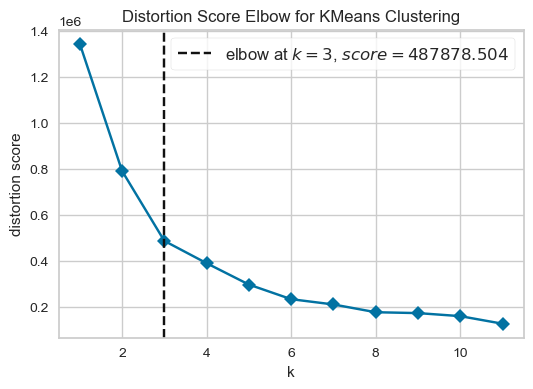

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [82]:
plt.figure(figsize=(6, 4))
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), timings=False)
visualizer.fit(rfm_scaled)  
plt.savefig('Elbow_Plot.png')
visualizer.show()

In [86]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(rfm_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm_val)
rfm_pd['Cluster'] = kmeans_scaled.fit_predict(rfm_scaled)
rfm_pd.head()

,user_id,Recency,Frequency,R_score,F_score,Cluster
0,65,0,2,4,2,0
1,77,1,2,4,2,0
2,113,1,1,4,1,0
3,126,4,1,2,1,2
4,130,0,3,4,3,0


In [89]:
 # Filter the original dataset based on cluster labels
 cluster_0 = rfm_pd[rfm_pd['Cluster'] == 0]
 cluster_1 = rfm_pd[rfm_pd['Cluster'] == 1]
 cluster_2 = rfm_pd[rfm_pd['Cluster'] == 2]

In [90]:
 cluster_0.describe()


,user_id,Recency,Frequency,R_score,F_score,Cluster
count,4.043120e+05,404312.000000,404312.000000,404312.000000,404312.000000,404312.0
mean,5.101821e+05,1.189020,2.641346,3.468388,2.317139,0.0
std,2.942947e+05,1.085762,1.492035,0.767726,1.030311,0.0
min,4.000000e+00,0.000000,1.000000,2.000000,1.000000,0.0
25%,2.557602e+05,0.000000,1.000000,3.000000,1.000000,0.0
50%,5.100420e+05,1.000000,2.000000,4.000000,2.000000,0.0
75%,7.660692e+05,2.000000,4.000000,4.000000,3.000000,0.0
max,1.018010e+06,3.000000,6.000000,4.000000,4.000000,0.0


In [91]:
 cluster_1.describe()


,user_id,Recency,Frequency,R_score,F_score,Cluster
count,5.489600e+04,54896.000000,54896.000000,54896.000000,54896.0,54896.0
mean,5.146939e+05,1.052609,10.038582,3.556962,4.0,1.0
std,2.942952e+05,1.356300,4.983145,0.797367,0.0,0.0
min,2.000000e+00,0.000000,7.000000,1.000000,4.0,1.0
25%,2.601045e+05,0.000000,7.000000,3.000000,4.0,1.0
50%,5.174935e+05,1.000000,9.000000,4.000000,4.0,1.0
75%,7.662680e+05,2.000000,11.000000,4.000000,4.0,1.0
max,1.017999e+06,9.000000,262.000000,4.000000,4.0,1.0


In [92]:
 cluster_2.describe()

,user_id,Recency,Frequency,R_score,F_score,Cluster
count,2.131960e+05,213196.000000,213196.000000,213196.000000,213196.000000,213196.0
mean,5.100816e+05,5.687372,1.861203,1.272707,1.729305,2.0
std,2.939374e+05,1.405500,1.227616,0.445352,0.910645,0.0
min,1.100000e+01,4.000000,1.000000,1.000000,1.000000,2.0
25%,2.562868e+05,4.000000,1.000000,1.000000,1.000000,2.0
50%,5.106525e+05,6.000000,1.000000,1.000000,1.000000,2.0
75%,7.627878e+05,7.000000,2.000000,2.000000,2.000000,2.0
max,1.018011e+06,9.000000,9.000000,2.000000,4.000000,2.0


In [94]:
# After we added the cluster_pred column in rfm_pd
def categorize_customers(row):
    if row['Cluster'] == 0:
        return 'Churn Risk Customers'
    elif row['Cluster'] == 1:
        return 'Potential Customers'
    elif row['Cluster'] == 2:
        return 'High-Value Customers'

rfm_pd['class'] = rfm_pd.apply(categorize_customers, axis=1)

# See the first 5 records.
rfm_pd.head()


,user_id,Recency,Frequency,R_score,F_score,Cluster,class
0,65,0,2,4,2,0,Churn Risk Customers
1,77,1,2,4,2,0,Churn Risk Customers
2,113,1,1,4,1,0,Churn Risk Customers
3,126,4,1,2,1,2,High-Value Customers
4,130,0,3,4,3,0,Churn Risk Customers


In [95]:
customer_class = rfm_pd.groupby('class')['user_id'].count().reset_index()
customer_class.columns = ['Customer Class', 'Counts']
customer_class.head()


,Customer Class,Counts
0,Churn Risk Customers,404312
1,High-Value Customers,213196
2,Potential Customers,54896


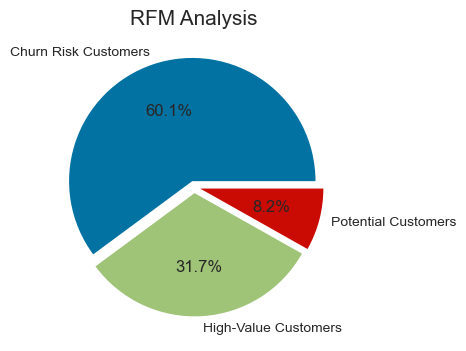

In [99]:
plt.figure(figsize=(4, 4))
plt.pie(customer_class['Counts'], labels=customer_class['Customer Class'], autopct='%1.1f%%', explode=[0.05]*3)
plt.title('RFM Analysis', fontsize=15)
plt.savefig('RFM Analysis.png', format='png', bbox_inches='tight')
plt.show()

 4. Predictive Behavior Modeling


In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [104]:
df_with_dow.head()

Row(user_id=1, item_id=4615417, category_id=4145813, behavior_type='PageView', timestamp=1511870864, event_time=datetime.datetime(2017, 11, 28, 14, 7, 44), event_date=datetime.date(2017, 11, 28), event_hour=14, event_dow='Tuesday', Day_order=2)

In [106]:
from pyspark.sql.functions import col, count

# 1. Sort by user_id and event_time
df_with_dow_time = df_with_dow.orderBy(['user_id', 'event_time'])

# 2. Count the number of interactions for each (item_id, user_id)
behavior_count = (
    df_with_dow_time
    .groupBy("item_id", "user_id")
    .agg(count("behavior_type").alias("Behavior_Count"))
)

# 3. Filter by the number of behaviors >= 5
filtered_bc = behavior_count.filter(col("Behavior_Count") >= 5)

# 4. Joining (join) with the original table
df_5M_filtered = df_with_dow_time.join(filtered_bc, on=["item_id", "user_id"], how="inner")

df_5M_filtered.show(5)


+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+---------+--------------+
|item_id|user_id|category_id|behavior_type| timestamp|         event_time|event_date|event_hour|event_dow|Day_order|Behavior_Count|
+-------+-------+-----------+-------------+----------+-------------------+----------+----------+---------+---------+--------------+
|    142| 932034|    4160459|     PageView|1512310629|2017-12-03 16:17:09|2017-12-03|        16|   Sunday|        7|             6|
|    142| 932034|    4160459|     PageView|1512313220|2017-12-03 17:00:20|2017-12-03|        17|   Sunday|        7|             6|
|    142| 932034|    4160459|     PageView|1512309968|2017-12-03 16:06:08|2017-12-03|        16|   Sunday|        7|             6|
|    142| 932034|    4160459|     PageView|1512311235|2017-12-03 16:27:15|2017-12-03|        16|   Sunday|        7|             6|
|    142| 932034|    4160459|     PageView|1512310735|2017-12-03 16:18:55|20

In [107]:
from pyspark.sql.functions import collect_list

# 1. Collecting the behaviors for each user_id and item_id in the form of a list
sequence = (
    df_5M_filtered
    .groupBy("item_id", "user_id")
    .agg(collect_list("behavior_type").alias("Sequence"))
)

# 2. Delete the item_id column (if not needed)
sequence = sequence.drop("item_id")

# 3. Display the first 5 lines
sequence.show(5, truncate=False)


+-------+-----------------------------------------------------------------------------------------------------+
|user_id|Sequence                                                                                             |
+-------+-----------------------------------------------------------------------------------------------------+
|192634 |[PageView, AddToCart, PageView, PageView, PageView]                                                  |
|932034 |[PageView, PageView, PageView, PageView, PageView, PageView]                                         |
|26503  |[PageView, PageView, PageView, Buy, PageView]                                                        |
|978561 |[AddToCart, PageView, PageView, PageView, PageView, PageView, PageView, PageView, PageView, PageView]|
|825475 |[Buy, PageView, PageView, PageView, Buy]                                                             |
+-------+-----------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import col

# Filter negative values
df_5M_filteredAbove0 = df_5M_filtered.filter(col("timestamp") >= 0)

# Convert to Pandas after filtering
df_5M_filtered_pandas = df_5M_filteredAbove0.toPandas()


In [77]:
# Time measurement with and without Spark for  Collecting the behaviors for each user_id and item_id in the form of a list
import time
from pyspark.sql import SparkSession

# 1) Without Spark (baseline)

start_time = time.time()
sequence_panda = (
    df_5M_filtered_pandas
    .groupby(["item_id", "user_id"])["behavior_type"]
    .agg(list)  
    .reset_index(name="Sequence")
)
end_time = time.time()
baseline_time = end_time - start_time
print(f"Baseline runtime: {baseline_time:.2f} seconds")


# 2) With Spark

start_time = time.time()
sequence_sprk = (
    df_5M_filteredAbove0
    .groupBy("item_id", "user_id")
    .agg(collect_list("behavior_type").alias("Sequence"))
)
end_time = time.time()
spark_time = end_time - start_time
print(f"Spark runtime: {spark_time:.2f} seconds")

# 3) Speedup
speedup = baseline_time / spark_time if spark_time > 0 else None
print(f"Speedup: {speedup:.2f}x")


Baseline runtime: 27.61 seconds
Spark runtime: 0.60 seconds
Speedup: 46.12x


In [ ]:
# convert from Spark DF to Pandas
sequence_pd = sequence.toPandas()


In [110]:
# convert from Spark DF to Pandas
sequence_pd = sequence.toPandas()


In [111]:
from sklearn.model_selection import train_test_split

# Train / Test split
sequence_train, sequence_test = train_test_split(sequence_pd, test_size=0.2, random_state=42)

# Validation / Test split
sequence_val, sequence_test = train_test_split(sequence_test, test_size=0.5, random_state=42)


In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# ========= Dataset =========
PADDING_IDX = 4
class UserBehaviorDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.token_to_idx = {
            'PageView': 0, 
            'AddToCart': 1, 
            'Buy': 2, 
            'Favorite': 3,  
            'Padding': PADDING_IDX
        }
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx, 1]

        # String Encoding
        sequence_idx = [self.token_to_idx[action] for action in sequence]

        # The introduction: everything except the last element
        input_seq = sequence_idx[:-1]
        # The goal: everything except the first element.
        target_seq = sequence_idx[1:]

        return torch.tensor(input_seq), torch.tensor(target_seq), torch.tensor(len(input_seq))

def pad_collate(batch):
    (xx, yy, lens) = zip(*batch)
    x_lens = torch.tensor(lens)

    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=PADDING_IDX)
    yy_pad = torch.nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=PADDING_IDX)
    return xx_pad, yy_pad, x_lens

# ========= Model =========
class LSTMBehaviorModel(nn.Module):
    def __init__(self, num_tokens, hidden_size=128, num_layers=3,dropout=0.1):
        super(LSTMBehaviorModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_tokens, hidden_size, padding_idx=PADDING_IDX)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout )
        self.fc = nn.Linear(hidden_size, num_tokens)
    def forward(self, x, x_lens):
        x = self.embed(x)
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        packed_out, _ = self.lstm(packed_x, (h0, c0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True, padding_value=PADDING_IDX)
        out = self.fc(out)
        return out

# ========= Training =========
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMBehaviorModel(num_tokens=5).to(device)

class_weights = torch.tensor([1.0, 1.5, 2.0, 1.2, 0.0], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=PADDING_IDX, reduction='none').to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_dataset = UserBehaviorDataset(sequence_train)
val_dataset = UserBehaviorDataset(sequence_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate)

best_val_loss = float('inf')
patience, patience_counter = 5, 0
num_epochs = 2
train_loss_list = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for x_padded, y_padded, x_lens in tqdm(train_loader):
        x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
        optimizer.zero_grad()
        output = model(x_padded, x_lens)
        loss = criterion(output.view(-1, 5), y_padded.view(-1))   
        loss = loss.mean()
        train_loss_list.append(loss.item())
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

        optimizer.step()
        total_train_loss += loss.item()
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_padded, y_padded, x_lens in val_loader:
            x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
            output = model(x_padded, x_lens)
            
            val_loss = criterion(output.view(-1, 5), y_padded.view(-1))
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean() 
            
            total_val_loss += val_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # EarlyStopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
            


100%|████████████████████████████████████████████████████████████████████████████| 63540/63540 [45:25<00:00, 23.31it/s]


Epoch 0: Train Loss = 0.3797, Val Loss = 4.4899


100%|████████████████████████████████████████████████████████████████████████████| 63540/63540 [44:04<00:00, 24.02it/s]


Epoch 1: Train Loss = 0.3784, Val Loss = 4.4869


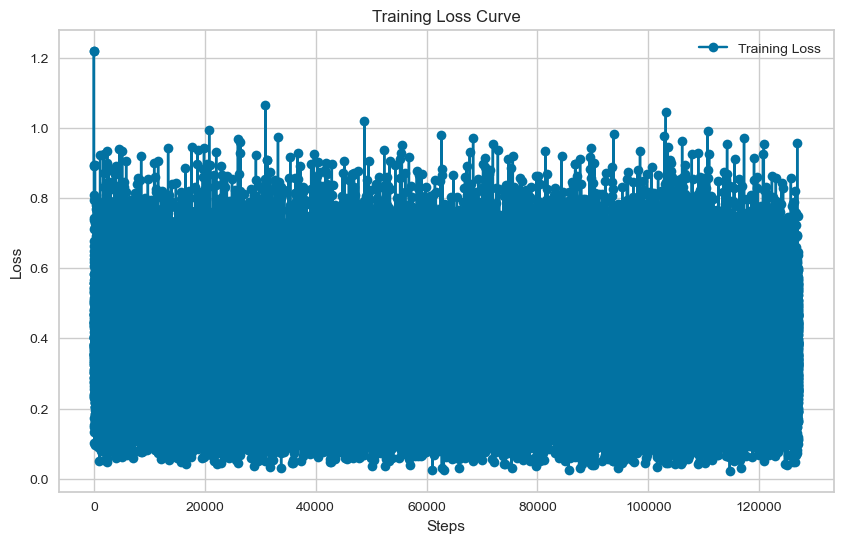

In [154]:
# plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(list(range(0, len(train_loss_list))), train_loss_list, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.png", dpi=600)
plt.show()

In [136]:
# ========= Evaluation =========
test_dataset = UserBehaviorDataset(sequence_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate)

model.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for x_padded, y_padded, x_lens in test_loader:
        x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
        output = model(x_padded, x_lens)
        preds = output.argmax(dim=-1)  # The expectation for each step was taken.
        for i, length in enumerate(x_lens):
            # We only compare up to the actual length.
            all_predictions.extend(preds[i, :length].tolist())
            all_labels.extend(y_padded[i, :length].tolist())

acc = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy (Next-Step Prediction): {acc:.4f}")

Test Accuracy (Next-Step Prediction): 0.8634


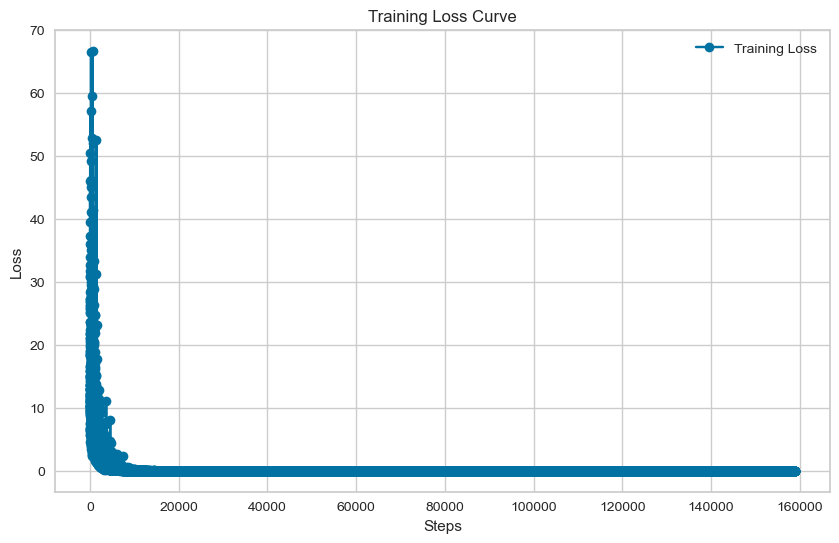

In [117]:
# plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(list(range(0, len(train_loss_list))), train_loss_list, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.png", dpi=600)
plt.show()

In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# ========= Dataset =========
PADDING_IDX = 4
class UserBehaviorDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.token_to_idx = {
            'PageView': 0, 
            'AddToCart': 1, 
            'Buy': 2, 
            'Favorite': 3,  
            'Padding': PADDING_IDX
        }
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx, 1]
        sequence_idx = [self.token_to_idx[action] for action in sequence]

        input_seq = sequence_idx[:-1]
        target_seq = sequence_idx[1:]

        return torch.tensor(input_seq), torch.tensor(target_seq), torch.tensor(len(input_seq))

def pad_collate(batch):
    (xx, yy, lens) = zip(*batch)
    x_lens = torch.tensor(lens)

    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=PADDING_IDX)
    yy_pad = torch.nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=PADDING_IDX)
    return xx_pad, yy_pad, x_lens


# ========= Model =========
class LSTMBehaviorModel(nn.Module):
    def __init__(self, num_tokens, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMBehaviorModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_tokens, hidden_size, padding_idx=PADDING_IDX)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_tokens)
    def forward(self, x, x_lens):
        x = self.embed(x)
        packed_x = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        packed_out, _ = self.lstm(packed_x, (h0, c0))
        out, _ = pad_packed_sequence(packed_out, batch_first=True, padding_value=PADDING_IDX)
        out = self.fc(out)
        return out


# ========= Training Setup =========
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMBehaviorModel(num_tokens=5, hidden_size=256, num_layers=3, dropout=0.3).to(device)

class_weights = torch.tensor([1.0, 1.5, 2.0, 1.2, 0.0], dtype=torch.float).to(device)

criterion_train = nn.CrossEntropyLoss(
    weight=class_weights, ignore_index=PADDING_IDX, reduction='none', label_smoothing=0.05
).to(device)

criterion_val = nn.CrossEntropyLoss(
    weight=class_weights, ignore_index=PADDING_IDX, reduction='mean'
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_dataset = UserBehaviorDataset(sequence_train)
val_dataset = UserBehaviorDataset(sequence_val)
train_loader = DataLoader(train_dataset, batch_size=46, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=46, shuffle=False, collate_fn=pad_collate)

best_val_loss = float('inf')
patience, patience_counter = 5, 0
num_epochs = 3


# ========= Training Loop =========
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for x_padded, y_padded, x_lens in tqdm(train_loader):
        x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
        optimizer.zero_grad()
        output = model(x_padded, x_lens)

        loss = criterion_train(output.view(-1, 5), y_padded.view(-1))
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_padded, y_padded, x_lens in val_loader:
            x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
            output = model(x_padded, x_lens)
            val_loss = criterion_val(output.view(-1, 5), y_padded.view(-1))
            total_val_loss += val_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step()

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# ========= Evaluation =========
test_dataset = UserBehaviorDataset(sequence_test)
test_loader = DataLoader(test_dataset, batch_size=46, shuffle=False, collate_fn=pad_collate)

model.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for x_padded, y_padded, x_lens in test_loader:
        x_padded, y_padded, x_lens = x_padded.to(device), y_padded.to(device), x_lens.to(device)
        output = model(x_padded, x_lens)
        preds = output.argmax(dim=-1)
        for i, length in enumerate(x_lens):
            all_predictions.extend(preds[i, :length].tolist())
            all_labels.extend(y_padded[i, :length].tolist())

acc = accuracy_score(all_labels, all_predictions)
print(f"✅ Test Accuracy (Next-Step Prediction): {acc:.4f}")


100%|████████████████████████████████████████████████████████████████████████████| 22101/22101 [35:49<00:00, 10.28it/s]


Epoch 0: Train Loss = 5.0377, Val Loss = 0.7042


100%|████████████████████████████████████████████████████████████████████████████| 22101/22101 [33:42<00:00, 10.93it/s]


Epoch 1: Train Loss = 5.0304, Val Loss = 0.7060


100%|████████████████████████████████████████████████████████████████████████████| 22101/22101 [36:08<00:00, 10.19it/s]


Epoch 2: Train Loss = 5.0294, Val Loss = 0.7054
✅ Test Accuracy (Next-Step Prediction): 0.8633


## RNN

In [146]:
 # rnn
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
class RNNBehaviorModel(nn.Module):
    def __init__(self, num_tokens, hidden_size=128, num_layers=1):
        super(RNNBehaviorModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(num_tokens, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, x_lens):
        x = self.embed(x)
        packed_x = pack_padded_sequence(
            x, x_lens.squeeze().cpu(), batch_first=True, enforce_sorted=False
        )
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        packed_out, _ = self.rnn(packed_x, h0)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.fc(out)
        return out

# ========= Training Setup =========
model = RNNBehaviorModel(num_tokens=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, reduction="none").to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float("inf")
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    for x_padded, y_padded, x_lens in tqdm(train_loader):
        x_padded, y_padded, x_lens = (
            x_padded.to(device),
            y_padded.to(device),
            x_lens.to(device),
        )

        optimizer.zero_grad()
        output = model(x_padded, x_lens)

        loss = criterion(output.view(-1, 5), y_padded.view(-1))
        loss = loss.view(x_padded.size(0), -1).sum(dim=1).mean()

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_padded, y_padded, x_lens in val_loader:
            x_padded, y_padded, x_lens = (
                x_padded.to(device),
                y_padded.to(device),
                x_lens.to(device),
            )
            output = model(x_padded, x_lens)
            val_loss = criterion(output.view(-1, 5), y_padded.view(-1))
            val_loss = val_loss.view(x_padded.size(0), -1).sum(dim=1).mean()
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch}: Avg. Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")


100%|█████████████████████████████████████████████████████████████████████████| 63540/63540 [40:25:27<00:00,  2.29s/it]


Epoch 0: Avg. Validation Loss: 3.1729


100%|████████████████████████████████████████████████████████████████████████████| 63540/63540 [11:56<00:00, 88.63it/s]


Epoch 1: Avg. Validation Loss: 3.2024


In [147]:
model = RNNBehaviorModel(num_tokens=5).to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for x_padded, y_padded, x_lens in test_loader:
        x_padded, y_padded, x_lens = (
            x_padded.to(device),
            y_padded.to(device),
            x_lens.to(device),
        )
        output = model(x_padded, x_lens)
        preds = output.argmax(dim=-1)

        for i, length in enumerate(x_lens.squeeze()):
            all_predictions.append(preds[i, length - 1].item())   # Prediction at the last step
            all_labels.append(y_padded[i, length - 1].item())     # The correct label at the last step.

accuracy = accuracy_score(all_labels, all_predictions)
print(f"✅ Test Accuracy: {accuracy:.4f}")

✅ Test Accuracy: 0.8520


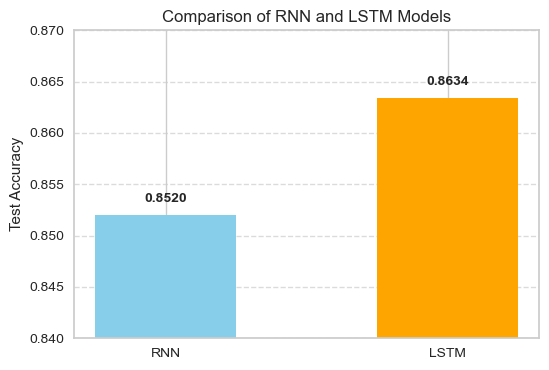

In [152]:
import matplotlib.pyplot as plt

# Test results
models = ["RNN", "LSTM"]
accuracies = [0.8520, 0.8634]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=["skyblue", "orange"], width=0.5)

# Add values above the columns
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f"{acc:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0.84, 0.87)
plt.ylabel("Test Accuracy")
plt.title("Comparison of RNN and LSTM Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
